In [1]:
!pip install lightgbm

     |████████████████████████████████| 2.0 MB 16.1 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.


In [1]:
import pandas as pd
import lightgbm as gbm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import time
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [2]:
#store = pd.HDFStore('X_pca.h5')
#X_pca = store['X_pca']

store = pd.HDFStore('X_frac_pca.h5')
X_pca = store['X_frac_pca']

store = pd.HDFStore('X_frac_mob.h5')
X_mob = store['X_frac_mob']

store = pd.HDFStore('X_frac_month.h5')
X_month = store['X_frac_month']

store = pd.HDFStore('X_frac_year.h5')
X_year = store['X_frac_year']

store = pd.HDFStore('y_frac_default.h5')
y_default = store['y_frac_default']

store = pd.HDFStore('y_frac_prepay.h5')
y_prepay = store['y_frac_prepay']

X_pca = X_pca.join(X_mob)
X_pca = X_pca.join(X_month)
X_pca = X_pca.join(X_year)

In [3]:
X_pca

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,mob,Orig_month,Orig_year
0,0.093127,0.092207,0.494277,-0.502171,2.210740,0.645226,0.518809,-1.251009,0.102798,-0.155370,-1.872736,0.456408,-0.436088,-0.204955,0.040391,9,1,2018
1,-1.148829,-1.523952,0.578549,0.395206,0.826511,0.892112,0.247240,-0.727809,0.032526,0.343827,-0.395095,0.183804,-0.079973,0.727229,-0.231855,10,12,2017
2,0.630276,-1.859233,-1.037141,1.116298,-0.983651,0.455403,-0.271425,0.416954,-0.052584,0.182261,-0.026139,0.102932,-0.579591,0.751029,0.066680,1,2,2018
3,0.150906,1.540984,-0.652540,0.263882,2.258937,0.715997,-0.127785,0.060508,0.023202,-0.311532,-1.664690,0.349264,-0.558741,-0.022529,0.720693,9,1,2018
4,-1.312144,-1.485046,0.662994,-0.109456,0.347366,0.839628,-0.036324,-0.188709,-0.011632,0.355584,-0.611471,0.298834,-0.938122,0.889392,-0.004444,20,4,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10381408,-0.316416,0.450575,-1.022290,-1.193427,2.088363,0.444149,-0.481775,0.678109,-0.012128,-0.400796,-0.250067,-0.025979,0.516297,-0.752435,1.181489,23,6,2017
10381409,-1.240803,-4.015243,1.405098,-1.306068,-1.084756,-2.077933,0.409458,-0.019641,0.046386,0.020057,0.204083,-0.302337,1.036334,-0.812650,-0.289726,9,6,2018
10381410,1.258057,-0.711763,-1.030782,-2.120177,0.946994,-0.540640,0.183373,-0.621273,0.087206,-0.165722,-0.066257,0.089758,0.036840,-0.874545,0.361843,44,1,2016
10381411,0.060714,-2.467273,1.256449,0.157799,-0.118184,-1.175913,-0.338862,0.808586,0.042788,-0.198221,0.788801,-0.156438,-0.557388,-0.257599,1.010280,3,12,2016


In [4]:
trainX, testX, trainy, testy = train_test_split(X_pca, y_default, test_size=0.2, random_state=2)
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testy))]

No Skill: ROC AUC=0.500
LGBMClassifier: ROC AUC=0.773


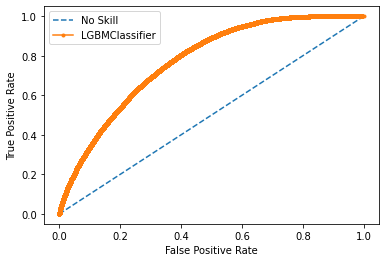

48.644816875457764 s


In [5]:
time_start = time.time()
model = gbm.LGBMClassifier(max_depth= 6, n_estimators=100)
model.fit(trainX, trainy)
time_end = time.time()

# save the model to disk
filename = 'lgbm_model_default.sav'

pickle.dump(model, open(filename, 'wb'))
model = pickle.load(open(filename, 'rb'))


# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('LGBMClassifier: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='LGBMClassifier')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()
print (time_end - time_start, "s")

In [6]:
trainX, testX, trainy, testy = train_test_split(X_pca, y_prepay, test_size=0.2, random_state=2)
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testy))]

No Skill: ROC AUC=0.500
LGBMClassifier: ROC AUC=0.643


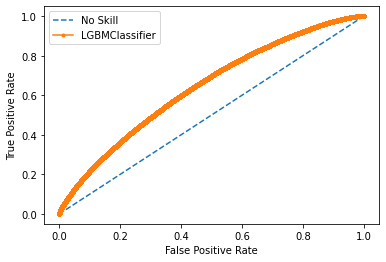

50.17778253555298 s


In [7]:
time_start = time.time()
model = gbm.LGBMClassifier(max_depth= 6, n_estimators=100)
model.fit(trainX, trainy)
time_end = time.time()

filename = 'lgbm_model_prepay.sav'
#filename = 'xgb_model_date_prepay.sav'

pickle.dump(model, open(filename, 'wb'))
model = pickle.load(open(filename, 'rb'))

# predict probabilities
lr_probs = model.predict_proba(testX)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('LGBMClassifier: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='LGBMClassifier')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()
print (time_end - time_start, "s")